In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.utils as torchU
import random as rand
import math
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
"""
  check if cuda is avaible and does some initializations regarding Cuda or Torch
"""
print(torch.__version__)
torch.cuda.is_available()
#torch.random.seed()

1.5.0+cu101


True

In [ ]:
!nvidia-smi

Sun Jun  7 15:16:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     7W /  75W |     10MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
"""
  Loading datasets and preparing the transformations

  transforms.ToTensor():
  Converts a PIL.Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
  So no normalization is required
"""
trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_classes = trainset.classes
testset_classes = testset.classes

In [ ]:
"""
  Setting up the class for logistic regression classifier
  parameters:
    layers: list containing the input sizes from layer to layer
"""
class Model(torch.nn.Module):
    def __init__(self,layers,layer_type):
        super(Model, self).__init__()
        self.net = []
        for i,j in zip(range(len(layers)-1),range(len(layer_type))):
          if layer_type[j] == "tanh":
            self.net.append(nn.Linear(layers[i],layers[i+1]))
            self.net.append(nn.Tanh())
            continue
          if layer_type[j] == "sigmoid":
            self.net.append(nn.Linear(layers[i],layers[i+1]))
            self.net.append(nn.Sigmoid())
            continue
          if layer_type[j] == "linear":
            self.net.append(nn.Linear(layers[i],layers[i+1]))
            continue
          if layer_type[j] == "relu":
            self.net.append(nn.Linear(layers[i],layers[i+1]))
            self.net.append(nn.ReLU())
            continue
        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        return self.net(x)

In [ ]:
def learn_one_batch(model,batch,labels,loss_func,optimizer,train=True):
  # put data and labals on GPU
  batch =  batch.cuda()
  labels = labels.cuda()
  # flatten the batch
  batch = torch.reshape(batch,[len(batch),32*32*3])
  # calculate prediction and error
  pred = model(batch)
  error = loss_func(pred,labels)
  pred_as_indices = torch.max(pred,dim=1).indices
  accuracy = float(((pred_as_indices == labels).sum().float() / float(len(labels))))

  if train:
    # backward + apply gradient descent
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
  
  return batch,labels,pred,pred_as_indices,float(error),accuracy


In [ ]:
def calculate_gradient_norm(model,layer_list):
  # gradient norm
  layer_counter = 0
  actual_layer = 0
  weights = None
  bias = None
  for p in list(filter(lambda p: p.grad is not None, model.parameters())):
    if layer_counter == 0:
      weights = p.data
      layer_counter += 1
      continue
    if layer_counter == 1:
      bias = p.data
      bias = torch.reshape(bias,[len(bias),1])
      layer_counter = 0
      #print(weights.shape)
      #print(bias.shape)
      weight_bias = torch.cat([weights, bias],dim=1)
      #print()
      # layer_list safes the gradient norm per layer in a list of lists
      layer_list[actual_layer].append(float(weight_bias.norm(2)))
      actual_layer += 1
      continue
  return layer_list

In [ ]:
"""
  Setting up the parameters for the network and learning
"""
layers = [32*32*3,pow(2,8),10]
number_layers = len(layers)-1
layers_type = ["sigmoid","linear"]
model = Model(layers,layers_type)
model = model.cuda()
lr = 0.0001
loss_func = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=0.99,nesterov=True,weight_decay=0.001)
max_epoches = 400
batch_size = pow(2,7)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,1,0.999)

# dataloader
train_dataloader = torchU.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
test_dataloader = torchU.data.DataLoader(testset,batch_size=len(testset),shuffle=False)

batch_counts = len(trainset)//batch_size

final_error_training = []
final_validation_error = []
final_accuracy_training = []
validation_accuracy = []
error_test = []
accuracy_test = []
learnrate = []
final_gradient_norm = []
for i in range(number_layers):
  final_gradient_norm.append([])
# Loop over epochs
for epoch in range(max_epoches):
  print("epoch: ",epoch)
  print("current learnrate: ", lr_scheduler.get_last_lr())
  # Training
  error_training = []
  accuracy_training = []
  gradient_norm = []
  for i in range(number_layers):
   gradient_norm.append([])
  # selects one batch at random for a single validation
  val_batch_ind = np.random.randint(batch_counts)
  counter = 0
  for local_batch, local_labels in train_dataloader:
    # skip the validation batch
    if val_batch_ind == counter:
      counter += 1
      val_batch = local_batch.clone()
      val_labels = local_labels.clone()
      continue
    else:
      counter += 1
    local_batch, local_labels,pred,pred_as_indices,error,accuracy = learn_one_batch(model,local_batch,local_labels,loss_func,optimizer) 
    # append error and accuracy
    error_training.append(float(error))
    accuracy_training.append(accuracy)

    # gradient norm
    gradient_norm = calculate_gradient_norm(model,gradient_norm)
  
  # outside batch loop, inside epoch loop
  with torch.no_grad():
    # compute validation error and accuracy
    val_batch, val_labels, pred, pred_as_indices, error, accuracy = learn_one_batch(model,val_batch,val_labels,loss_func,optimizer,train=False) 
    final_validation_error.append(float(error))
    validation_accuracy.append(accuracy)

    # since batchsize = len(testset) this is probably a nice workaround
    # means there is exactly 1 batch 
    # compute test error and accuracy
    for batch, labels in test_dataloader:
      test_batch, test_labels,pred,pred_as_indices,error,accuracy = learn_one_batch(model,batch,labels,loss_func,optimizer,train=False) 
      error_test.append(error)
      accuracy_test.append(accuracy)
    # Take confusion matrix data from last epoch
    if epoch == max_epoches-1:
      actuals = []
      predictions = []
      for i in test_labels:
        actuals.append(testset_classes[i.item()])
      for i in pred_as_indices:
        predictions.append(testset_classes[i.item()])

  final_error_training.append(np.mean(error_training))
  final_accuracy_training.append(np.mean(accuracy_training))
  for i in range(number_layers):
    final_gradient_norm[i].append(np.mean(gradient_norm[i]))
  error_training.clear()
  accuracy_training.clear()
  learnrate.append(float(lr_scheduler.get_last_lr()[0]))
  lr_scheduler.step()


epoch:  0
current learnrate:  [0.0001]
epoch:  1
current learnrate:  [9.99e-05]
epoch:  2
current learnrate:  [9.980010000000001e-05]
epoch:  3
current learnrate:  [9.970029990000001e-05]
epoch:  4
current learnrate:  [9.960059960010001e-05]
epoch:  5
current learnrate:  [9.950099900049991e-05]
epoch:  6
current learnrate:  [9.94014980014994e-05]
epoch:  7
current learnrate:  [9.930209650349791e-05]
epoch:  8
current learnrate:  [9.920279440699441e-05]
epoch:  9
current learnrate:  [9.910359161258741e-05]
epoch:  10
current learnrate:  [9.900448802097483e-05]
epoch:  11
current learnrate:  [9.890548353295386e-05]
epoch:  12
current learnrate:  [9.88065780494209e-05]
epoch:  13
current learnrate:  [9.870777147137147e-05]
epoch:  14
current learnrate:  [9.860906369990011e-05]
epoch:  15
current learnrate:  [9.85104546362002e-05]
epoch:  16
current learnrate:  [9.8411944181564e-05]
epoch:  17
current learnrate:  [9.831353223738244e-05]
epoch:  18
current learnrate:  [9.821521870514505e-05

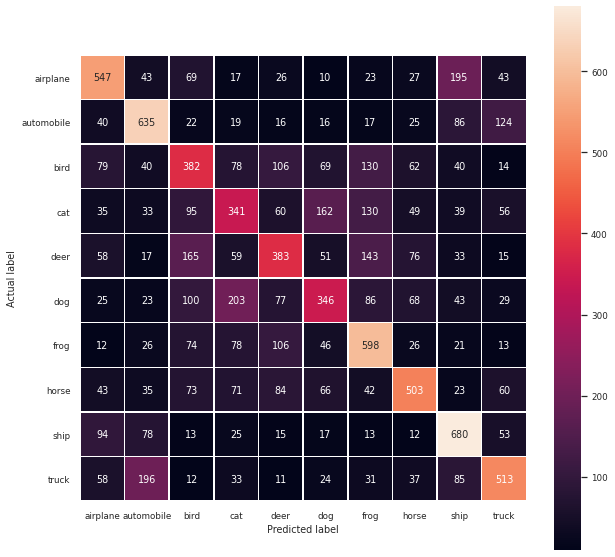

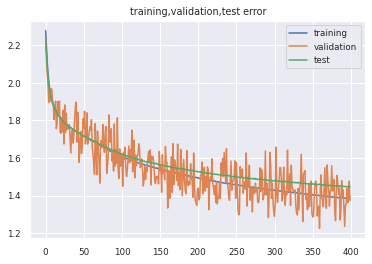

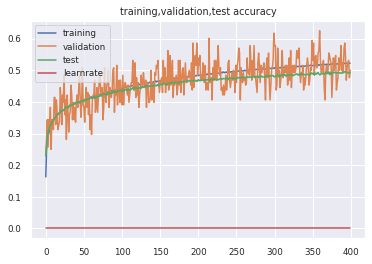

2


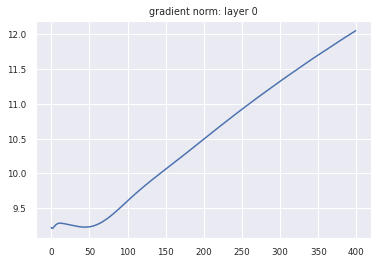

2


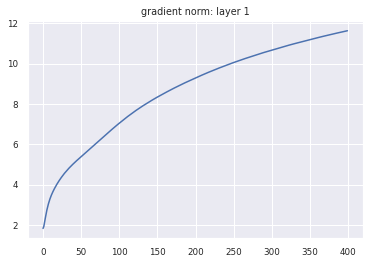

In [ ]:
"""
  Plotting: Confusion matrix, gradient norm for each layer, loss and accuracy for each epoch
"""
# Plot confusion matrix
#actuals, predictions = [i.item() for i in actuals], [i.item() for i in predictions]
cm = confusion_matrix(actuals, predictions, testset_classes)
cm = pd.DataFrame(cm, testset_classes, testset_classes)
plt.figure(figsize=(10,10))
sn.set(font_scale=.8) # for label size
sn.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.show()

# Plot loss for validation, test and training
plt.title("training,validation,test error")
plt.plot(final_error_training, label="training")   
plt.plot(final_validation_error, label = "validation")
plt.plot(error_test, label = "test")
plt.legend(loc="upper right")
plt.show()

# Plot accuracy for validation, test and training
plt.title("training,validation,test accuracy")
plt.plot(final_accuracy_training, label="training")   
plt.plot(validation_accuracy, label = "validation")
plt.plot(accuracy_test, label = "test")
plt.plot(learnrate,label="learnrate")
plt.legend(loc="upper left")
plt.show()

# Plot gradient norm
for i in range(number_layers):
  plt.title("gradient norm: layer " + str(int(i)))
  print(len(final_gradient_norm))
  plt.plot(final_gradient_norm[i])
  plt.show()
